# Synthesizing Images from the CIFAR Dataset using Conditional Deep Convolutional Generative Adversarial Networks (DCGANs).

This notebook is a simple demonstration that generates synthetic images mimicking the CIFAR-10 data using conditioned Deep Convolutional Generative Adversarial Networks (DCGANS).  The approach taken here follows from my previous example of using an MLP-style conditioned GAN to generate syntetic data mimicking the MNIST dataset; however, we now use a convolutional network with residual connections and group normalization.

The results achieved are OK but I think that additional steps for stabilizing the training process are necessary in order to get really excellent results, i.e., Wasserstein loss, gradient penalties and an architecture that more closely resembles style-GAN.  Keep an eye out for future notebooks demonstrating these techniques.

Also, I'm learning that CIFAR-10 isn't the best dataset for synthetic image generation because it actually doesn't contain quite enough data to represent the diversity of the classes it contains.  In other words, a relatively small discriminator is capable of completly overfitting the data.

In [1]:
import math
import pickle
import random

import tqdm.notebook as tqdm
import munch

import numpy as np
import matplotlib.pyplot as plt

import skimage as ski

import torch as th
import torchmetrics as tm
import torchinfo

In [2]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 11)

import IPython

## CIFAR Dataset

This is just a Torch dataset for the standard CIFAR-10 data.

In [3]:
class CIFAR(th.utils.data.Dataset):
    '''CIFAR-10 dataset with labels.
    '''
    def __init__(self):
        '''Initialize a new CIFAR-10 dataset.
        '''
        super().__init__()
        self.imgs, self.labels = self._load_imgs()
        
    @staticmethod
    def _load_imgs():
        '''Load all the images.  The dataset is small enough
        to keep everything in memory on the CPU-side.
        '''
        imgs, labels = [], []
        
        for batch in range(1, 6):
            with open(f'../data/cifar/cifar-10/data_batch_{batch}', mode='rb') as fh:
                batch_data = pickle.load(fh, encoding='latin1')
                
            batch_imgs = batch_data['data'].reshape((-1, 3, 32, 32)) / 255.
            batch_labels = batch_data['labels']
            
            imgs.append(th.as_tensor(batch_imgs, dtype=th.float32))
            labels.append(th.as_tensor(batch_labels, dtype=th.int64))

        return th.cat(imgs, dim=0), th.cat(labels, dim=0)

    def __getitem__(self, idx):
        '''Load the image and corresponding label at index `idx`.
        The images undergo horizontal flipping augmentation with
        a 50% probability.
        '''
        img = self.imgs[idx]
        if random.random() < 0.5:
            img = img.flip(2)
            
        label = self.labels[idx] + 1
        
        return img, label
    
    def __len__(self):
        '''Number of images in the dataset.
        '''
        return self.imgs.shape[0]
    
    def plot(self, idx):
        '''Plot the image at index `idx`.
        '''
        fig, ax = plt.subplots()
        
        img = self.imgs[idx].movedim(0, -1)
        ax.imshow(img)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)
        
    def plot_montage(self, n=36, seed=42):
        '''Plot a montage of `n` images selected at random
        using the given random number `seed`.
        '''
        rng = random.Random(seed)
        idxs = rng.sample(range(len(self)), n)
        
        imgs = th.stack([self[idx][0] for idx in idxs], dim=0).movedim(1, -1)
        
        montage = ski.util.montage(imgs, channel_axis=-1)
        
        fig, ax = plt.subplots()
        ax.imshow(montage)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)

In [4]:
data = CIFAR()
len(data)

50000

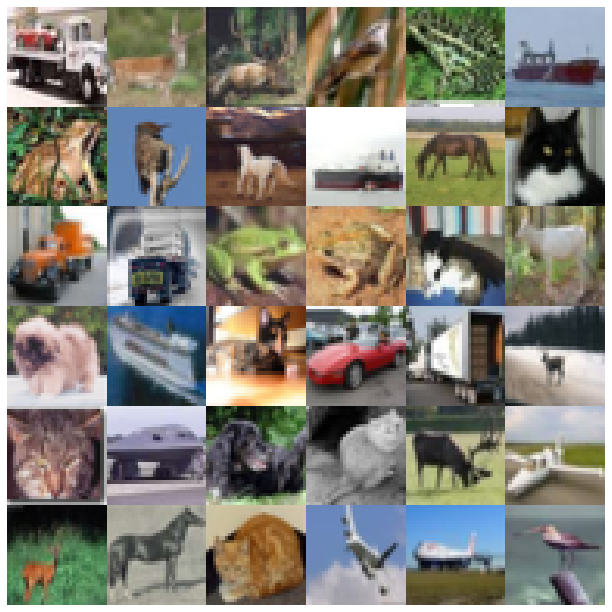

In [5]:
data.plot_montage();

## Custom Layers

We create custom linear and convolutional layers that use Xavier weight initialization and have a default of "same" padding built into our convolutions.

In [6]:
class _Linear(th.nn.Linear):
    '''Linear layer with Xavier weight initialization.
    '''
    def reset_parameters(self):
        th.nn.init.xavier_normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)

In [7]:
class _Conv2d(th.nn.Conv2d):
    '''Convolutional layer with Xavier weight initialization
    and "same" padding built in.
    '''
    def __init__(self, in_chans, out_chans, kernel_size, stride=1, bias=True):
        super().__init__(
            in_chans, out_chans,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride,
            bias=bias,
        )
        
    def reset_parameters(self):
        th.nn.init.xavier_normal_(self.weight)
        if getattr(self, 'bias', None) is not None:
            th.nn.init.zeros_(self.bias)

## Residual Convolution Block

In [8]:
class _ResidBlock(th.nn.Module):
    '''A residual-style convolutional block.  With two convolutional
    layers surrounding a single SiLU nonlinearity and two group
    normalization layers following each convolution.
    '''
    def __init__(self, in_chans, out_chans, kernel_size):
        super().__init__()
        
        self.remix = th.nn.Identity() if in_chans == out_chans \
            else _Conv2d(in_chans, out_chans, kernel_size=1)
        
        self.resid = th.nn.Sequential(
            _Conv2d(in_chans, out_chans, kernel_size=kernel_size, bias=False),
            th.nn.GroupNorm(8, out_chans),
            #th.nn.LeakyReLU(inplace=True, negative_slope=1e-3),
            th.nn.SiLU(),
            _Conv2d(out_chans, out_chans, kernel_size=1, bias=False),
            th.nn.GroupNorm(8, out_chans),
        )
        
        # We divide by sqrt(2) because the sum of two normal distributions
        # has variance of sqrt(2) and we initialize assuming zero mean
        # and unit variance.
        self.register_buffer('s', th.as_tensor(2.).rsqrt(), persistent=False)
        
    def forward(self, x):
        return self.s * (self.remix(x) + self.resid(x))

## Generator

Our generator first unflattens the latent vector using a nearest-neighbor upsampling approach, i.e., repeating the values along the horizontal and vertical axes to create an image.  This step may be a simple reshape if the images are 1x1 at their smallest size.  The network then consists of multiple residual convolutional layers followed by pixel-shuffle upsampling until we have the desired image size.

In [9]:
class _GlobalUpsample(th.nn.Module):
    '''Global upsampling repeates each dimension to the desired size.
    '''
    def __init__(self, size):
        super().__init__()
        self.size = size
        
    def forward(self, x):
        batch_size, num_chans = x.shape
        return (
            x.view(batch_size, num_chans, 1, 1)
            .expand(batch_size, num_chans, *self.size)
        )
    
    def extra_repr(self):
        return f'size={self.size}'

In [10]:
class _Upsample(th.nn.Module):
    '''Pixel-shuffle upsampling wiht a 2x factor.
    '''
    def forward(self, x):
        return th.nn.functional.pixel_shuffle(x, upscale_factor=2)

In [11]:
# Specification for a residual/convolutional layer
_LayerSpec = collections.namedtuple(
    '_LayerSpec', ('num_filters', 'kernel_size'),
    defaults=(3,))

In [12]:
_default_generator_layer_specs = (
    (256, 3), #  1
    (256, 3), #  2
    (128, 3), #  4
    ( 64, 3), #  8
    ( 32, 5), # 16
)

class Generator(th.nn.Module):
    '''Generator composed of multiple residual/convolutional layers.
    '''
    def __init__(self, latent_dim=118, num_labels=10, img_chans=3, img_size=32,
                 layer_specs=_default_generator_layer_specs):
        '''Initialize a new generator.
        
        Args:
            latent_dim (int):
                The size of the latent input vector.
            num_labels (int):
                The number of class labels used for conditioning.
            img_chans (int):
                The number if channels in the output image.
            img_size (int):
                The size of the output image, assumed to be square.
            layer_specs (_LayerSpec):
                The specifications describing the number of features
                and kernel size in each residual/convolutional layer.
        '''
        super().__init__()
        
        self.latent_dim = latent_dim
        self.num_labels = num_labels
        self.img_chans = img_chans
        self.img_size = img_size

        layer_specs = tuple(itertools.starmap(_LayerSpec, layer_specs))

        small_img_size = img_size
        for layer_spec in layer_specs[1:]:
            small_img_size //= 2

        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, self.latent_dim + self.num_labels
        for layer_idx, layer_spec in enumerate(layer_specs):
            num_filters, kernel_size = layer_spec
            layer_in, layer_out = layer_out, num_filters
            
            # Pixel shuffle
            if layer_idx > 0:
                layer_in //= 4

            layer = th.nn.Sequential(
                _GlobalUpsample((small_img_size, small_img_size)) if layer_idx == 0 \
                    else _Upsample(),
                
                _ResidBlock(
                    layer_in, layer_out,
                    kernel_size=kernel_size,
                ),
            )
            
            self.hidden.append(layer)

        layer_in, layer_out = layer_out, self.img_chans
        self.visible = _Conv2d(layer_in, layer_out, kernel_size=1)

    def forward(self, z, labels):
        '''Generator forward pass.
        
        Args:
            z:
                A tensor containing the latent vector
                used for generation.
            labels:
                A tensor containing integer class labels
                used for conditioning.
        '''
        batch_size, latent_dim = z.shape
        assert latent_dim == self.latent_dim
        
        assert labels.shape == (batch_size,)
        indicators = th.zeros(batch_size, self.num_labels, device=labels.device)
        indicators.scatter_(1, labels[:, None], 1.).sub_(0.5)

        x = th.cat((z, indicators), dim=1)
 
        x = self.visible(self.hidden(x))
        assert x.shape == (batch_size, self.img_chans, self.img_size, self.img_size)

        return th.sigmoid(x + 0.5)
    
    @th.no_grad()
    def plot_montage(self, n=36, label=None):
        '''Plot of montage of `n` images generated from random
        latent vectors and the provided class `label`s.  If `label`
        is `None`, then random labels will be chosen.
        '''
        device = self.visible.weight.device
        
        if label is None:
            labels = th.randint(0, self.num_labels, size=(n,), device=device)
        else:
            labels = th.ones(n, dtype=th.int64) * label
            labels = labels.to(device)
        
        z = th.randn(n, self.latent_dim, device=device)
        imgs = self(z, labels).cpu().movedim(1, -1)
        
        montage = ski.util.montage(imgs, channel_axis=-1)
        fig, ax = plt.subplots()
        ax.imshow(montage)
        ax.axis('off')
        
        return munch.Munch(fig=fig, ax=ax)

In [13]:
generator = Generator()
generator

Generator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _GlobalUpsample(size=(2, 2))
      (1): _ResidBlock(
        (remix): _Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
        (resid): Sequential(
          (0): _Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(8, 256, eps=1e-05, affine=True)
          (2): SiLU()
          (3): _Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): GroupNorm(8, 256, eps=1e-05, affine=True)
        )
      )
    )
    (1): Sequential(
      (0): _Upsample()
      (1): _ResidBlock(
        (remix): _Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (resid): Sequential(
          (0): _Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(8, 256, eps=1e-05, affine=True)
          (2): SiLU()
          (3): _Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): GroupNorm(

In [14]:
torchinfo.summary(generator)

Layer (type:depth-idx)                        Param #
Generator                                     --
├─Sequential: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─_GlobalUpsample: 3-1              --
│    │    └─_ResidBlock: 3-2                  394,496
│    └─Sequential: 2-2                        --
│    │    └─_Upsample: 3-3                    --
│    │    └─_ResidBlock: 3-4                  230,656
│    └─Sequential: 2-3                        --
│    │    └─_Upsample: 3-5                    --
│    │    └─_ResidBlock: 3-6                  98,944
│    └─Sequential: 2-4                        --
│    │    └─_Upsample: 3-7                    --
│    │    └─_ResidBlock: 3-8                  24,896
│    └─Sequential: 2-5                        --
│    │    └─_Upsample: 3-9                    --
│    │    └─_ResidBlock: 3-10                 14,496
├─_Conv2d: 1-2                                99
Total params: 763,587
Trainable params: 76

## Visualing the distribution of network activations

It's important to ensure that our networks have a good weight initialization.  Although this is generally true when training deep networks, it appears to be especially important when training GANs because if either the generator or descriminator performs better initially, it can throw off the balance between these two components, leading to slow training or instability during training.

In order to ensure that we have a good weight initialization, we construct an "activation tracker" class that will track the outputs of our networks.  This class is a designed as a python context manager and only runs within the context.  We can then later examine the activations at each layer in order to ensure that they are roughly zero mean and unit variance.

In [15]:
class _ActivationTracker:
    '''A context manager that tracks the activations
    output at each layer of a network.
    '''
    def __init__(self, module):
        '''Initialize a new activation tracker for
        a given torch `module`.
        '''
        self.module = module
        self.handles = []
        self.activations = {}

    def __enter__(self):
        '''When the context manager is entered, register
        a forward hook to track the activations.
        '''
        self.activations.clear()
        self._register_forward_hooks()
        return self

    def __exit__(self, *args, **kwargs):
        '''Unregister the forward hook when the context
        exits.  That way, we don't continue to track
        activations.
        '''
        self._deregister_forward_hooks()

    def _register_forward_hooks(self):
        for name, module in self.module.named_modules():
            def hook(model, x, y, name=name):
                self.activations[name] = y.detach().cpu()
        
            self.handles.append(module.register_forward_hook(hook))

    def _deregister_forward_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles.clear()
        
    def __getitem__(self, key):
        '''Get the network activations, detached and in
        CPU-side memory, for the given key.  Keys follow
        the standard torch naming conventions.
        '''
        return self.activations[str(key)]

In [16]:
# Run a forward pass of the generator with some random normal
# latent vectors and random class labels.
with th.no_grad(), _ActivationTracker(generator) as g_activations:
    labels = th.randint(0, generator.num_labels, size=(2,))
    z = th.randn(2, generator.latent_dim)
    im = generator(z, labels)

(torch.Size([2, 3, 32, 32]),
 tensor(0.5520),
 tensor(0.2331),
 tensor(0.0019),
 tensor(0.9941))

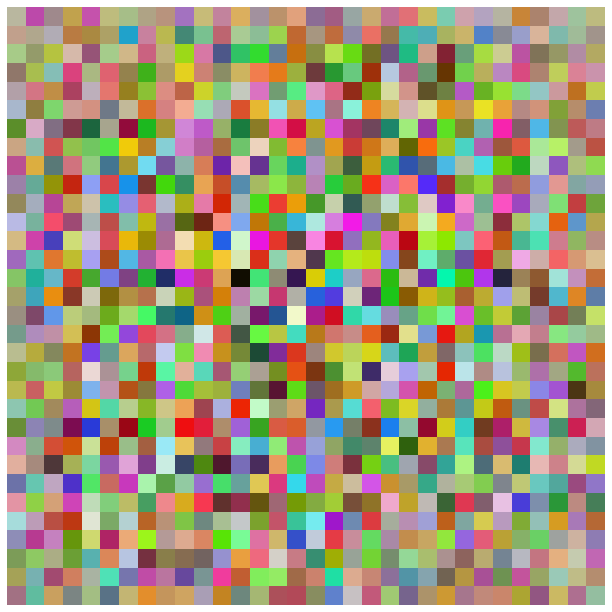

In [17]:
# Plot the outputs and some statistics
plt.imshow(im[0].movedim(0, -1))
plt.axis('off')
im.shape, im.mean(), im.std(), im.min(), im.max()

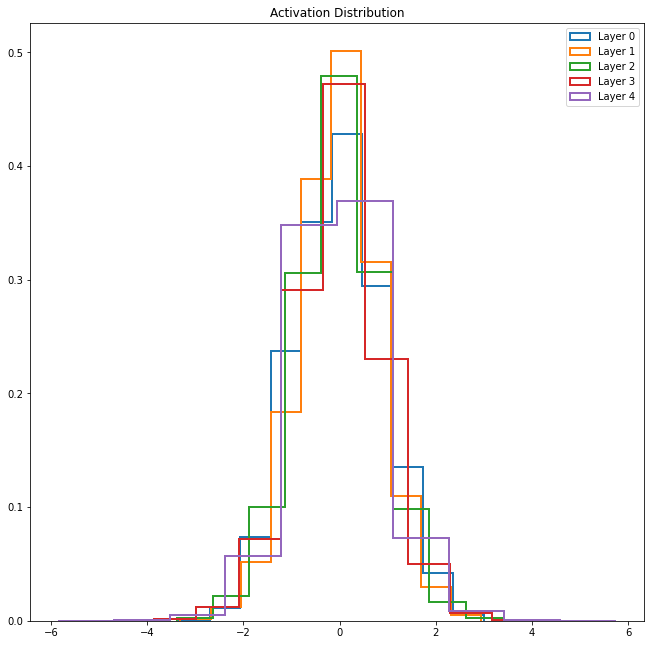

In [18]:
# Plots histograms showing the distributions of the
# network activations at each layer.
for layer_idx in range(len(generator.hidden)):
    activations = g_activations[f'hidden.{layer_idx}'].numpy()
    plt.hist(
        activations.ravel(),
        histtype='step',
        density=True,
        linewidth=2,
        label=f'Layer {layer_idx}',
    );

plt.legend();
plt.title('Activation Distribution');

## Discriminator

Our discriminator first concatenates the input images along with the mean of all images in the batch.  This is a form of "minibatch discrimination" that helps to prevent mode collapse.  The network then consists of multiple residual convolutional blocks with 2x downsampling layers between them.  We use a binomial blurring downsample operation as described in [Making Convolutional Networks Shift Invariant Again](https://arxiv.org/pdf/1904.11486.pdf).  We then apply a global average pooling layer followed by a final linear layer to produce logits describing the class membership predictions.  Note that the global average pooling step may be a noop if the images are 1x1 at their smallest size.

In [19]:
class _Downsample(th.nn.Module):
    '''Binomial blurring downsampling layer with 2x stride.
    '''
    def __init__(self):
        super().__init__()
        kernel = th.as_tensor([1., 2., 1.])
        kernel /= kernel.sum()
        self.register_buffer('kernel', kernel, persistent=False)

    def forward(self, x):
        batch_size, num_chans, height, width = x.shape

        x = x.view(-1, 1, height, width)
        x = th.nn.functional.pad(x, (1,)*4, mode='replicate')

        # The binomial blur filter is spatially separable, so we convolve
        # with a 1D kernel along both the vertial and horizontal axes.
        x = th.conv2d(x, self.kernel[None, None, :, None], stride=(2, 1))
        x = th.conv2d(x, self.kernel[None, None, None, :], stride=(1, 2))
        _, _, new_height, new_width = x.shape

        return x.view(batch_size, num_chans, new_height, new_width)

In [20]:
class _GlobalDownsample(th.nn.Module):
    '''Global average pooling layer.
    '''
    def forward(self, x):
        return x.mean(dim=(-2, -1))

In [21]:
_default_discriminator_layer_specs = (
    ( 32, 5), # 16
    ( 64, 3), #  8
    (128, 3), #  4
    (256, 3), #  2
    (256, 3), #  1
)

class Discriminator(th.nn.Module):
    '''A discriminator (classifier) composed of multiple
    residual/convolutional layers.
    '''
    def __init__(self, img_chans=3, img_size=32, num_classes=11,
                 layer_specs=_default_discriminator_layer_specs,
                 means=(0.4914, 0.4822, 0.4465), stdevs=(0.2470, 0.2435, 0.2616)):
        '''Initialize a new discriminator.
        
        Args:
            img_chans (int):
                The number of channels in the input images.
            img_size (int):
                The size of the input images, assumed to be square.
            num_classes (int):
                The number of class labels.  This should be the number
                of class labels used for conditioning in the generator
                plus one for the fake label.
            layer_specs (_LayerSpec):
                The specifications describing the number of features
                and kernel size in each residual/convolutional layer.
            means (tuple(float)):
                The means used for standardization, one per input
                channel.
            stdevs (tuple(float)):
                The standard deviations used for standardization,
                one per input channel.
        '''
        super().__init__()
        
        self.register_buffer(
            'means', th.as_tensor(means).view(1, -1, 1, 1), persistent=False)
        self.register_buffer(
            'rstdevs', 1. / th.as_tensor(stdevs).view(1, -1, 1, 1), persistent=False)

        self.img_chans = img_chans
        self.img_size = img_size
        self.num_classes = num_classes

        self.hidden = th.nn.Sequential()
        layer_in, layer_out = None, self.img_chans * 2
        num_levels = len(layer_specs)
        for layer_idx, layer_spec in enumerate(layer_specs):
            num_filters, kernel_size = layer_spec
            layer_in, layer_out = layer_out, num_filters
            self.hidden.append(
                th.nn.Sequential(
                    _ResidBlock(
                        layer_in, layer_out,
                        kernel_size=kernel_size,
                    ),
                    _GlobalDownsample() if layer_idx == num_levels - 1 \
                        else _Downsample(),
                )
            )

        layer_in, layer_out = layer_out, self.num_classes
        self.visible = _Linear(layer_in, layer_out)
        
    def forward(self, x):
        '''Forward pass of the discriminator returns a tensor
        of logits predicting the class membership for each image
        in `x`.
        '''
        batch_size, in_chans, height, width = x.shape
        assert in_chans == self.img_chans
        assert height == width == self.img_size
        
        x = (x - self.means) * self.rstdevs

        x_mean = x.mean(dim=0, keepdim=True).expand(batch_size, -1, height, width)
        x = th.cat((x, x_mean), dim=1)

        return self.visible(self.hidden(x))

In [22]:
discriminator = Discriminator()
discriminator

Discriminator(
  (hidden): Sequential(
    (0): Sequential(
      (0): _ResidBlock(
        (remix): _Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1))
        (resid): Sequential(
          (0): _Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): SiLU()
          (3): _Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): GroupNorm(8, 32, eps=1e-05, affine=True)
        )
      )
      (1): _Downsample()
    )
    (1): Sequential(
      (0): _ResidBlock(
        (remix): _Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (resid): Sequential(
          (0): _Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (2): SiLU()
          (3): _Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        )
      )


In [23]:
torchinfo.summary(discriminator)

Layer (type:depth-idx)                        Param #
Discriminator                                 --
├─Sequential: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─_ResidBlock: 3-1                  6,176
│    │    └─_Downsample: 3-2                  --
│    └─Sequential: 2-2                        --
│    │    └─_ResidBlock: 3-3                  24,896
│    │    └─_Downsample: 3-4                  --
│    └─Sequential: 2-3                        --
│    │    └─_ResidBlock: 3-5                  98,944
│    │    └─_Downsample: 3-6                  --
│    └─Sequential: 2-4                        --
│    │    └─_ResidBlock: 3-7                  394,496
│    │    └─_Downsample: 3-8                  --
│    └─Sequential: 2-5                        --
│    │    └─_ResidBlock: 3-9                  656,384
│    │    └─_GlobalDownsample: 3-10           --
├─_Linear: 1-2                                2,827
Total params: 1,183,723
Trainable params

Again, we visualize the distributions of the network activations for the discriminator in order to ensure that we have an acceptible weight initialization.

In [24]:
with th.no_grad(), _ActivationTracker(discriminator) as d_activations:
    logits = discriminator(im)

im.shape, im.mean(), im.std(), im.min(), im.max()

(torch.Size([2, 3, 32, 32]),
 tensor(0.5520),
 tensor(0.2331),
 tensor(0.0019),
 tensor(0.9941))

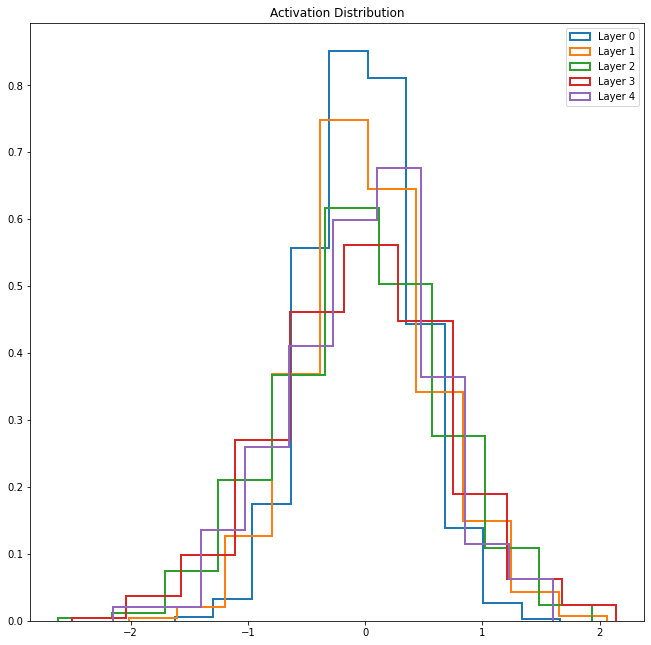

In [25]:
for layer_idx in range(len(discriminator.hidden)):
    activations = d_activations[f'hidden.{layer_idx}.1'].numpy()
    plt.hist(
        activations.ravel(),
        density=True,
        histtype='step',
        linewidth=2,
        label=f'Layer {layer_idx}',
    );

plt.legend();
plt.title('Activation Distribution');

## Adversarial Training

Now that the generator and discriminator are defined, we setup the training procedure.  This is a very simple adversarial training method where the discriminator minimizes cross-entropy for labeling real images as real and fake images as fake.  Simultaneously, the generator is trained produce fake images that the discriminator will label as real.  We incorporate constant label smoothing in order to prevent a catastrophic loss of stability that can occur if the descriminator fits the data nearly perfectly.

Note that catastrophic mode collapse typically occurs if the discriminator is able to perfectly fit the training data.  It turns out that this is fairly easily achieved with this network architecture over the CIFAR-10 dataset.  In order to prevent this, we measure the accuracy of the discriminator and terminate training before a given threshold is reached.

In [26]:
def smooth_cross_entropy(logits, targs, smooth):
    '''Smoothed cross entropy modifies the targets to fall within
    the range `[1. - smooth, smooth]` instead of `[0, 1]`.
    '''
    batch_size, num_classes = logits.shape
    device = logits.device
    
    targs_smooth = th.zeros(batch_size, num_classes, device=device)
    targs_smooth[:, 0] = 1. - smooth
    targs_smooth.scatter_(1, targs[:, None], smooth)

    return th.nn.functional.cross_entropy(logits, targs_smooth)

In [27]:
def train(generator, discriminator, data, max_epochs=300, max_acc=0.99, batch_size=128,
          lr=0.0002, lr_decay=0.985, label_smooth=0.9, plot_epochs=None, device=0):
    '''Perform class-conditioned adversarial training for the given `generator`,
    `discriminator` and `data`.

    generator (torch.Module):
        The generator module should take a batch of random latent vectors as
        inputs and produce a batch images as outputs.
    discriminator (torch.Module):
        The discriminator should take a batch of images as inputs and assign
        a binary class labels, fake or real, as outputs.
    data (torch.utils.data.Dataset):
        A Torch dataset that produces greyscale images in HW format.
    max_epochs (int):
        The maximum number of training epochs.
    max_acc (float):
        The maximum classification accuracy for the discriminator
        over the training data.  If the measured accuracy exceeds
        this threshold, training is terminated.
    batch_size (int):
        The batch size.
    lr (float):
        The learning rate to use.
    lr_decay (float):
        Exponential decay rate for the learning rate, applied after
        each training epoch.
    label_smooth (float):
        The constant label smoothing to use so that targets will fall
        between `[1. - label_smooth, label_smooth]` instead of `[0, 1]`.
    plot_epochs (None or int):
        Number of epochs between plotting a sample image montage.
        If `None` (default) then no montage is plotted.  This feature
        only works from within Jupyter notebooks.
    device (int):
        The GPU device ID to use.
    '''
    # Move to desired device
    generator.to(device)
    discriminator.to(device)

    # Place in training mode
    generator.train()
    discriminator.train()
    
    # Initialize optimizers
    g_opt = th.optim.RMSprop(generator.parameters(), alpha=0.999, lr=lr)
    d_opt = th.optim.RMSprop(discriminator.parameters(), alpha=0.999, lr=lr)

    
    # Initialize learning rate schedulers
    g_sched = th.optim.lr_scheduler.ExponentialLR(g_opt, gamma=lr_decay)
    d_sched = th.optim.lr_scheduler.ExponentialLR(d_opt, gamma=lr_decay)
    
    # Metrics
    lrs = []
    g_losses, d_losses = [], []
    
    accuracies = []
    accuracy = tm.classification.MulticlassAccuracy(
        num_classes=discriminator.num_classes).to(device)
    confusion = tm.classification.MulticlassConfusionMatrix(
        num_classes=discriminator.num_classes, normalize='true').to(device)

    # Initialize data loader
    dataloader = th.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    
    # Plotting handle for IPython
    dh = None

    # For each training epoch
    for epoch in (ebar := tqdm.trange(max_epochs, desc='epoch', leave=True)):
        # Reset metrics
        g_losses_step, d_losses_step = [], []
        accuracy.reset()
        confusion.reset()
        
        # For each batch
        for imgs, labels in (sbar := tqdm.tqdm(dataloader, desc='batch', leave=False)):
            # Move images and targets to desired device
            real_imgs = imgs.to(device, non_blocking=True)
            real_targs = labels.to(device, non_blocking=True)
            fake_targs = th.zeros(batch_size, dtype=th.int64, device=device)

            ## Generator

            rand_targs = th.randint(
                1, discriminator.num_classes, size=(batch_size,), device=device)

            z = th.randn(batch_size, generator.latent_dim, device=device)
            fake_imgs = generator(z, rand_targs - 1)

            fake_logits = discriminator(fake_imgs)
            g_loss = smooth_cross_entropy(fake_logits, rand_targs, label_smooth)

            g_losses_step.append(g_loss.item())

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            ## Discriminator
            
            rand_targs = th.randint(
                1, discriminator.num_classes, size=(batch_size,), device=device)

            with th.no_grad():
                z = th.randn(batch_size, generator.latent_dim, device=device)
                fake_imgs = generator(z, rand_targs - 1)

            fake_logits = discriminator(fake_imgs)
            fake_loss = smooth_cross_entropy(fake_logits, rand_targs, 1. - label_smooth)
            
            real_logits = discriminator(real_imgs)
            real_loss = smooth_cross_entropy(real_logits, real_targs, label_smooth)
            
            d_loss = (fake_loss + real_loss) / 2.
            d_losses_step.append(d_loss.item())
            
            with th.no_grad():
                accuracy.update(fake_logits, fake_targs)
                accuracy.update(real_logits, real_targs)

                confusion.update(fake_logits, fake_targs)
                confusion.update(real_logits, real_targs)

            d_opt.zero_grad()
            d_loss.backward()            
            d_opt.step()

        # Store metrics
        lrs.append(g_opt.param_groups[0]['lr'])
        g_losses.append(sum(g_losses_step) / len(g_losses_step))
        d_losses.append(sum(d_losses_step) / len(d_losses_step))
        accuracies.append(accuracy.compute().item())

        # Update progress bar
        ebar.set_postfix({
            'lr': lrs[-1],
            'g_loss': g_losses[-1],
            'd_loss': d_losses[-1],
            'acc': accuracies[-1],
        })

        # Update the learning rate scheduler
        g_sched.step()
        d_sched.step()
        
        # Plot example images during training
        if plot_epochs is not None and epoch % plot_epochs == 0:
            generator.eval()
            plt_result = generator.plot_montage()
            generator.train()
            
            if dh is None:
                dh = IPython.display.display(
                    plt_result.fig, display_id=True)
            else:
                dh.update(plt_result.fig)
            plt.close(plt_result.fig)
            
        if accuracies and accuracies[-1] > max_acc:
            ebar.close()
            break
            
    confusion = confusion.compute().cpu().numpy()

    # Place generator and discriminator back in eval mode
    generator.eval()
    discriminator.eval()

    # Move generator and discriminator back to CPU
    generator.cpu()
    discriminator.cpu()
    
    return munch.Munch(
        lrs=lrs,
        g_losses=g_losses,
        d_losses=d_losses,
        accuracies=accuracies,
        confusion=confusion,
    )

In [28]:
result = train(generator, discriminator, data, device=1)

epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Metrics

Next, let's visualize a few metrics.  We see the learning rate and the loss for both the generator and discriminator.  The loss values seem to suggest stability during training and that the generator has a difficult time keeping up with the discriminator.  We also see the accuracy for the discriminator and the corresponding confusion matrix.  Clearly, the discriminator is able to completely overfit the data in the CIFAR-10 training dataset.

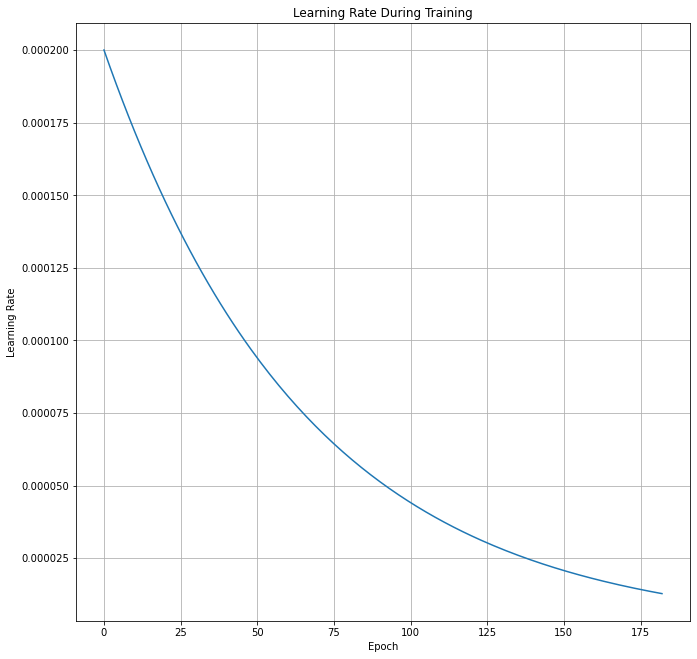

In [29]:
plt.plot(result.lrs)
plt.title('Learning Rate During Training');
plt.xlabel('Epoch');
plt.ylabel('Learning Rate');
plt.grid();

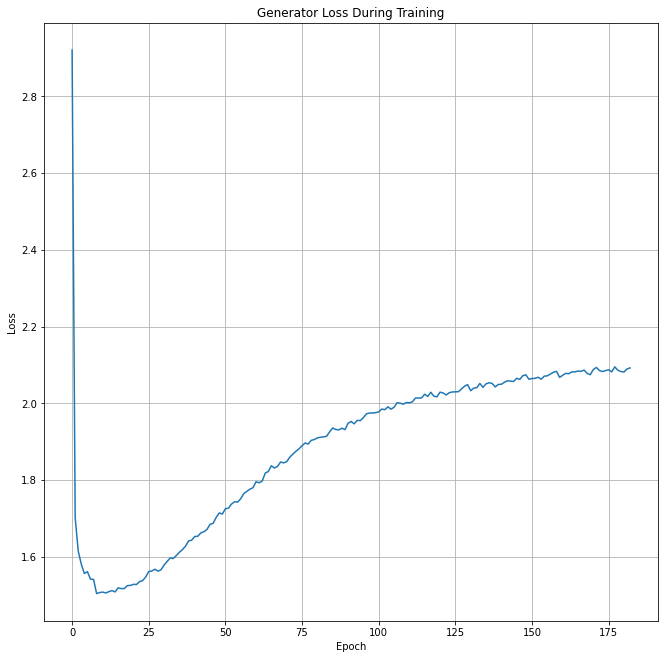

In [30]:
plt.plot(result.g_losses)
plt.title('Generator Loss During Training');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.grid();

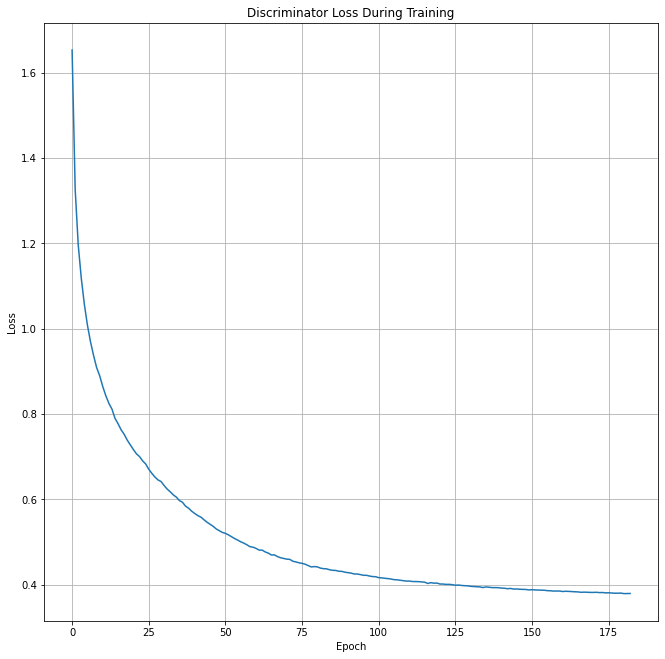

In [31]:
plt.plot(result.d_losses)
plt.title('Discriminator Loss During Training');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.grid();

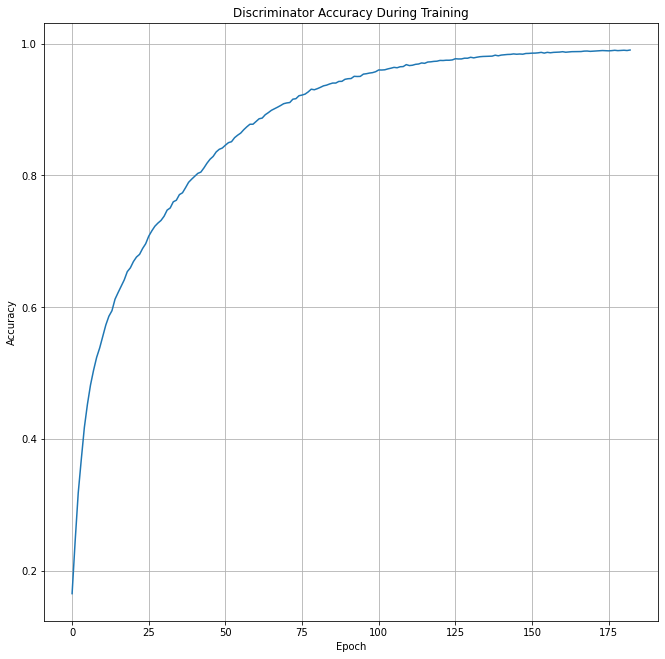

In [32]:
plt.plot(result.accuracies)
plt.title('Discriminator Accuracy During Training');
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.grid();

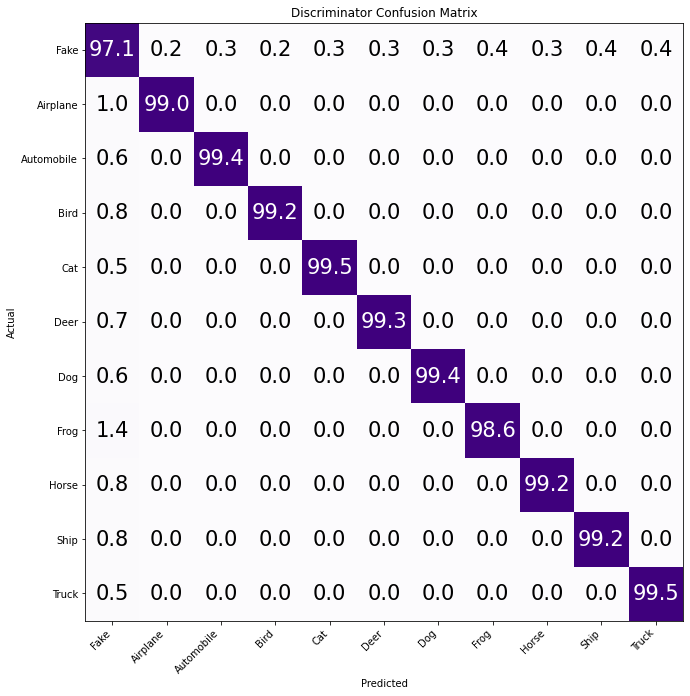

In [33]:
label_names = [
    'Fake',
    'Airplane',
    'Automobile',
    'Bird',
    'Cat',
    'Deer',
    'Dog',
    'Frog',
    'Horse',
    'Ship',
    'Truck',
]

confusion = 100. * result.confusion

fig, ax = plt.subplots()
ax.matshow(confusion, cmap=plt.cm.Purples)

for (i, j), z in np.ndenumerate(confusion):
    ax.text(j, i, f'{z:0.1f}', ha='center', va='center',
            color=('white' if z > 50 else 'black'), fontsize=21)
    
ax.set_xticks(ticks=list(range(len(label_names))), labels=label_names, rotation=45, ha='right')
ax.set_yticks(ticks=list(range(len(label_names))), labels=label_names)
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)

ax.set_title('Discriminator Confusion Matrix')
ax.set_xlabel('Predicted');
ax.set_ylabel('Actual');

## Examples of Generated Images

Finally, let's print some synthetic images for random labels as well as for fixed class labels.  Although it appears that our GAN working, I would say the images don't quite pass as looking real.

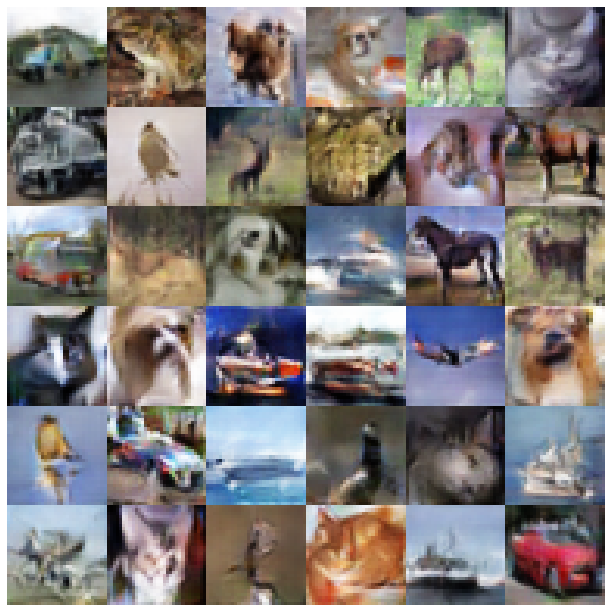

In [34]:
generator.plot_montage();

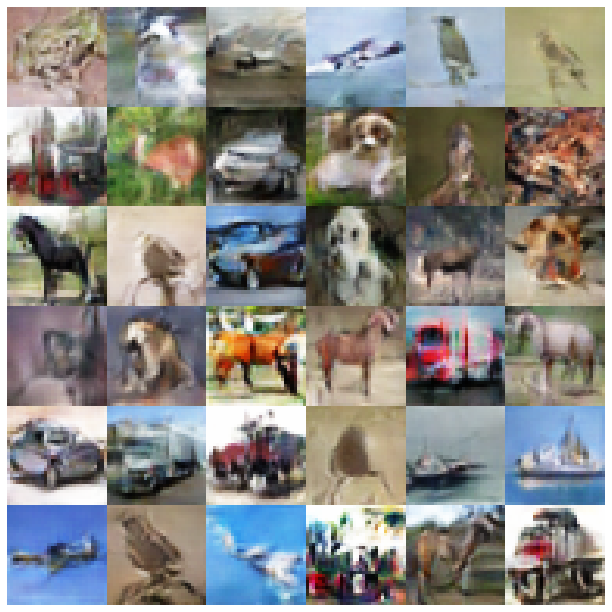

In [35]:
generator.plot_montage();

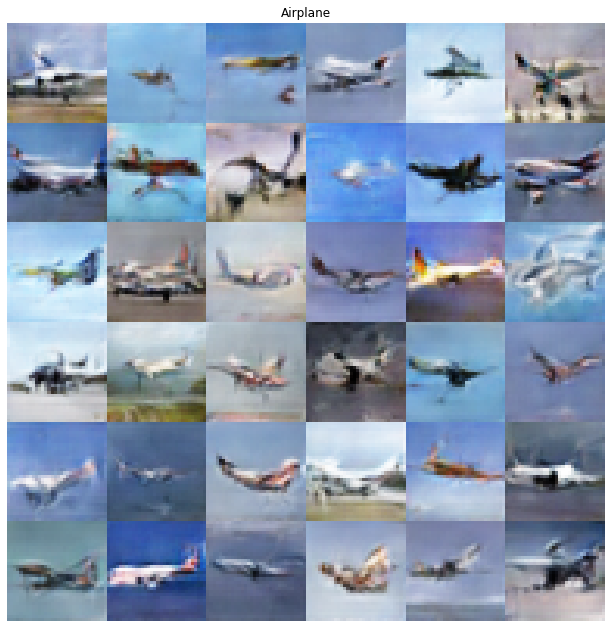

In [36]:
generator.plot_montage(label=0);
plt.title('Airplane');

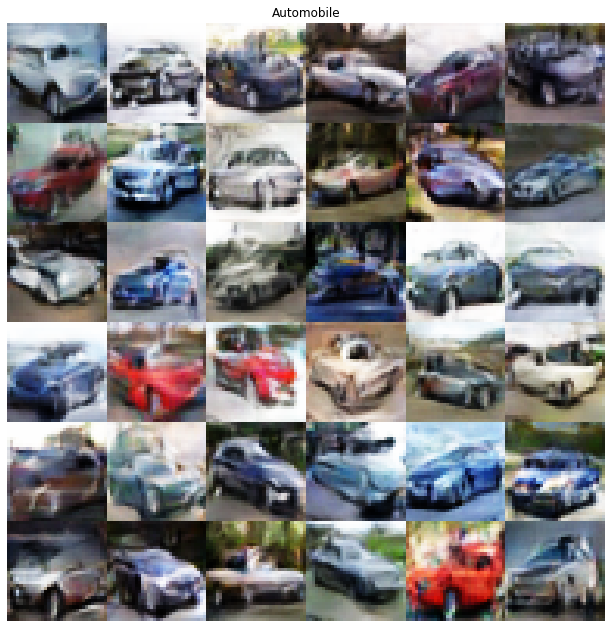

In [37]:
generator.plot_montage(label=1);
plt.title('Automobile');

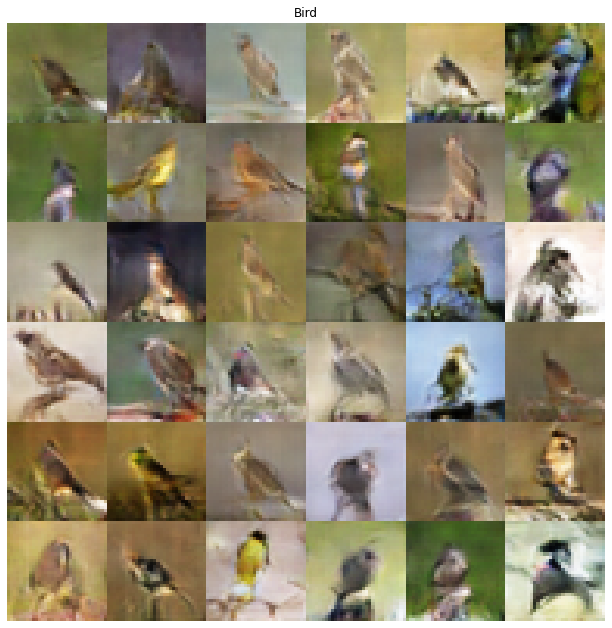

In [38]:
generator.plot_montage(label=2);
plt.title('Bird');

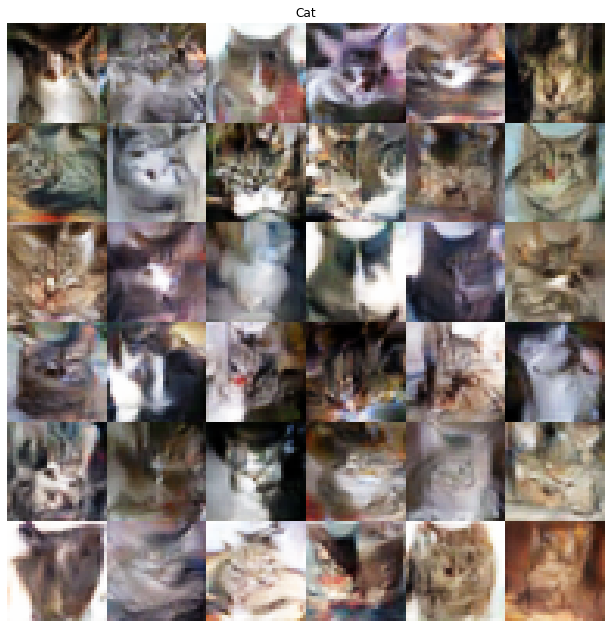

In [39]:
generator.plot_montage(label=3);
plt.title('Cat');

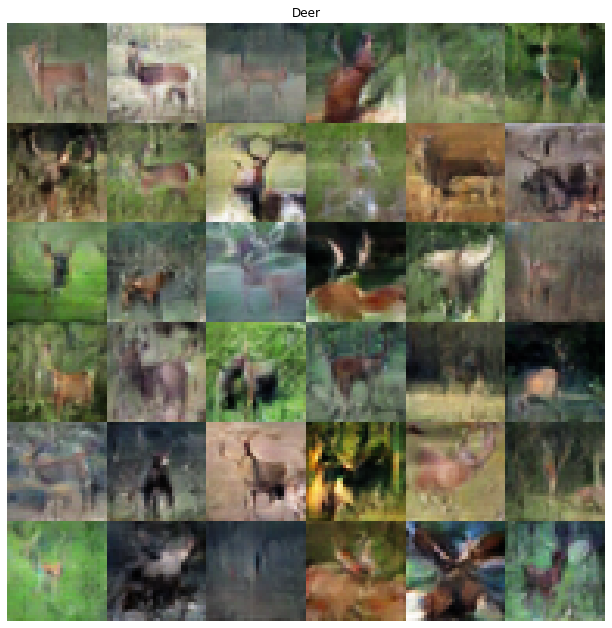

In [40]:
generator.plot_montage(label=4);
plt.title('Deer');

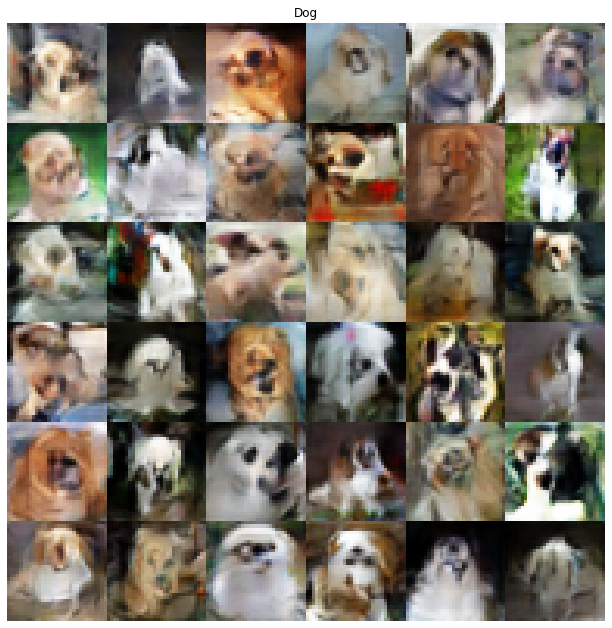

In [41]:
generator.plot_montage(label=5);
plt.title('Dog');

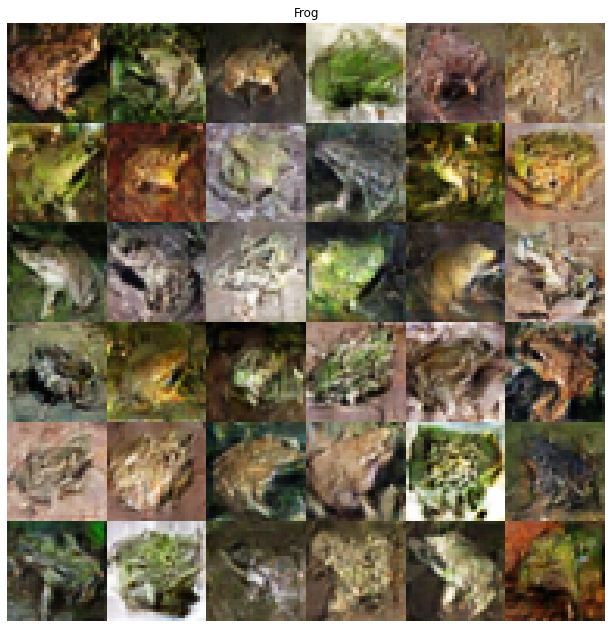

In [42]:
generator.plot_montage(label=6);
plt.title('Frog');

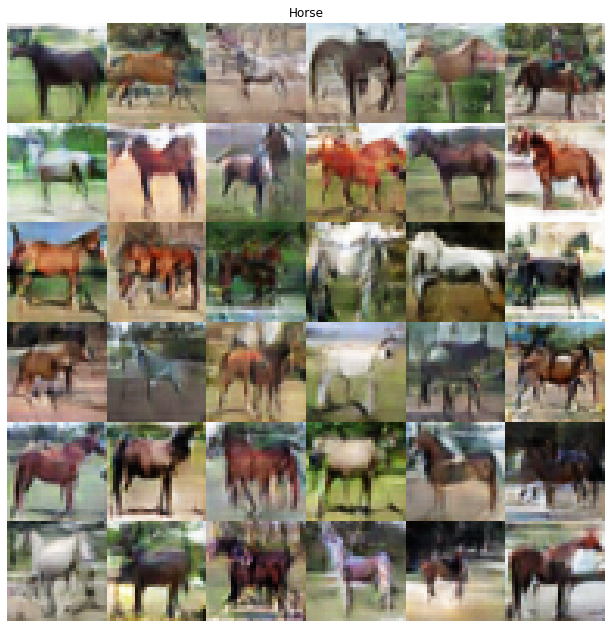

In [43]:
generator.plot_montage(label=7);
plt.title('Horse');

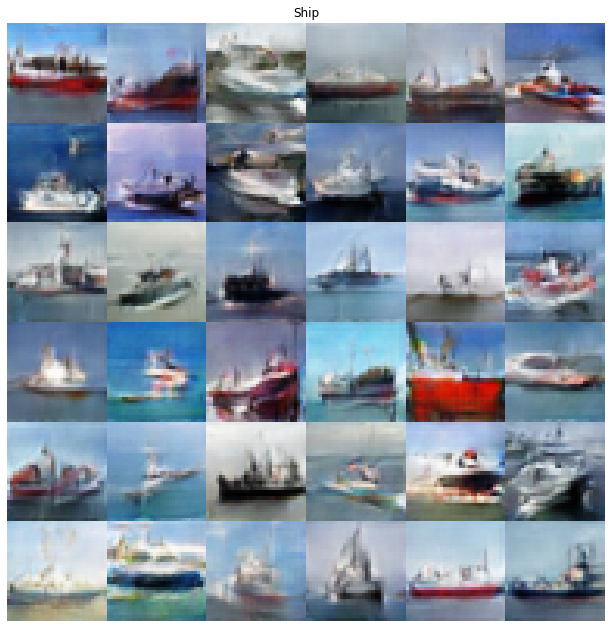

In [44]:
generator.plot_montage(label=8);
plt.title('Ship');

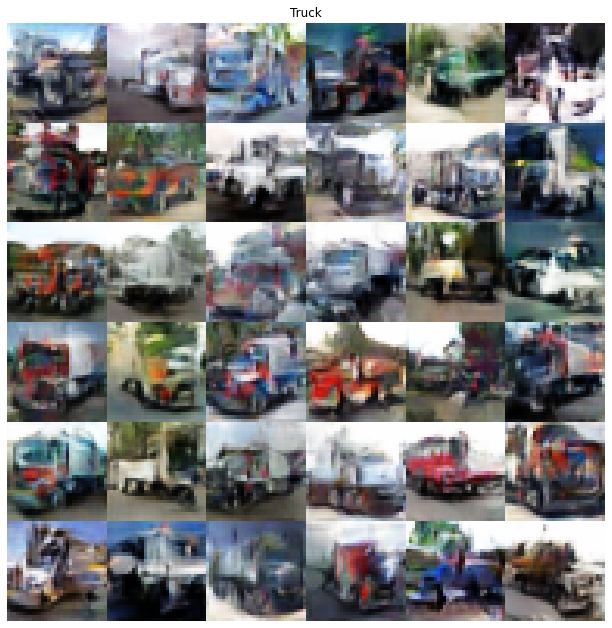

In [45]:
generator.plot_montage(label=9);
plt.title('Truck');

And that's all for my initial demonstration of using residual DCGANs to mimick the CIFAR-10 dataset.  Stay tuned for future notebooks that will examine other datasets and more advanced techniques for regularizing the GAN training procedure!